In [2]:
import os
import numpy as np
import tomlkit
import torch
import matplotlib.pyplot as plt
from DTransformer.data import KTData, Transform
from DTransformer.model import DTransformer


DATA_DIR = "../data"
data_name = 'assist09'

datasets = tomlkit.load(open(os.path.join(DATA_DIR, "datasets.toml")))
dataset = datasets[data_name]

test_data = KTData(os.path.join(DATA_DIR, dataset["test"]), dataset["inputs"])
data = test_data[12]

In [3]:
args = {'d_model': 128, 'n_heads': 8, 'n_know': 32, 'n_layers': 3, 'from_file': '../output/DT_assist09.pt'}

model = DTransformer(
    dataset["n_questions"],
    dataset["n_pid"],
    d_model=args['d_model'],
    n_heads=args['n_heads'],
    n_know=args['n_know'],
    n_layers=args['n_layers'],
)

model.load_state_dict(torch.load(args['from_file'], map_location=lambda s, _: s))
model.eval();

In [7]:
q, s, pid = data.get('q', 's', 'pid')
q = q.unsqueeze(0)
s = s.unsqueeze(0)
if pid is not None:
    pid = pid.unsqueeze(0)
with torch.no_grad():
    # q_emb: (bs, seq_len, d_model)
    # z: (bs, seq_len, n_know * d_model)
    # know_params: (n_know, d_model)->(n_know, 1, d_model)
    q_emb, s_emb, lens, p_diff = model.embedding(q, s, pid)
    z, q_scores, k_scores = model(q_emb, s_emb, lens)
    query = model.know_params.unsqueeze(1).expand(-1, z.size(1), -1).contiguous()
    z = z.expand(model.n_know, -1, -1).contiguous()
    h = model.readout(z, query)
    y = model.out(torch.cat([query, h], dim=-1)).squeeze(-1)
    y = torch.sigmoid(y)

y.size()

torch.Size([32, 183])

In [67]:
def trace_map(alpha, figsize, cmap='RdYlGn'):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    im = ax.pcolormesh(alpha, edgecolors='w', linewidth=0.4, cmap=cmap, clim=(0,1))
    ax.invert_yaxis()
    ax.set_xticks(np.arange(0, alpha.shape[1]+1, 5))
    ax.set_yticks(np.arange(0, alpha.shape[0]+1, 5))
    cbar = plt.colorbar(im, ax=ax, location='right')

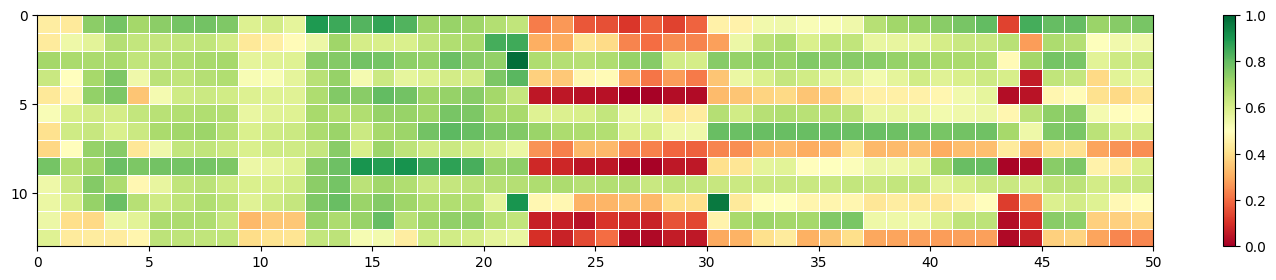

In [75]:
trace_map(y[12:25, :50].numpy(), (18, 3))